In [ ]:
evals = list() 
ae_evals = list()

In [162]:
importlib.reload(utils.common)
importlib.reload(evaluation)
importlib.reload(models.NeuralLogicRec)
import utils.common
import evaluation
import importlib
import numpy as np
import time
from models.ConstraintAutoRec import ConstraintAutoRec 
import models.NeuralLogicRec
import tensorflow as tf
import pandas as pd
from models.NeuralLogicRec import item_cf, user_cf, diversity_constraint, Constraint, And, Or, Implies, Forall, Not, Equiv


import itertools

ml_small = utils.common.ml_small
ml_big = utils.common.movie_lens


In [163]:
constraints = list()
constraints.append(Constraint(weight=0.4, formula=item_cf))
constraints.append(Constraint(weight=1.0, formula=user_cf))
@tf.function
def likes_equiv(model, outputs):
    return Forall(Equiv(outputs['rec'], outputs['likes']))
constraints.append(Constraint(weight=0.75, formula=likes_equiv))
@tf.function
def novelty_constraint(model, outputs):
    return Forall(Implies(outputs['popular'], Not(outputs['rec'])))
constraints.append(Constraint(weight=0.25, formula=novelty_constraint))
constraints.append(Constraint(weight=0.25, formula=diversity_constraint))
constraints

[Constraint(weight=0.4, formula=<tensorflow.python.eager.def_function.Function object at 0x7fa85fce4390>),
 Constraint(weight=1.0, formula=<tensorflow.python.eager.def_function.Function object at 0x7fa8602283c8>),
 Constraint(weight=0.75, formula=<tensorflow.python.eager.def_function.Function object at 0x7fa860037160>),
 Constraint(weight=0.25, formula=<tensorflow.python.eager.def_function.Function object at 0x7fa85ff0f080>),
 Constraint(weight=0.25, formula=<tensorflow.python.eager.def_function.Function object at 0x7fa85fce4588>)]

In [164]:
ev = evaluation.Evaluation(ml_big)
nlr = models.NeuralLogicRec.NLR(ml_big['user'], ml_big['dimensions'], epochs=1, embedding_dim=40, batch_size=48, nr_hidden_layers=3, nr_item_samples = 4096, constraints=constraints)

In [165]:
for i in range(4):
    nlr.train(utils.common.load_dataset(ml_big), ml_big['train']['records'])
    ae_evals.append(ev.evaluate_single_thread(nlr, max_nr_batches=16))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch #0 Loss at step 12: 0.4898, time: 20.923
Epoch #1 Loss at step 12: 0.4192, time: 2.646 Train accuracy 0.673, Validation accuracy 0.214
Epoch #2 Loss at step 12: 0.3684, time: 2.652 Train accuracy 0.634, Validation accuracy 0.128
Epoch #3 Loss at step 12: 0.3868, time: 2.634 Train accuracy 0.648, Validation accuracy 0.125
Epoch #4 Loss at step 12: 0.3130, time: 2.643 Train accuracy 0.653, Validation accuracy 0.157


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch #0 Loss at step 12: 0.2854, time: 2.651 Train accuracy 0.676, Validation accuracy 0.252
Epoch #1 Loss at step 12: 0.2631, time: 2.629 Train accuracy 0.660, Validation accuracy 0.245
Epoch #2 Loss at step 12: 0.2505, time: 2.634 Train accuracy 0.650, Validation accuracy 0.141
Epoch #3 Loss at step 12: 0.2171, time: 2.640 Train accuracy 0.662, Validation accuracy 0.189
Epoch #4 Loss at step 12: 0.2003, time: 2.647 Train accuracy 0.676, Validation accuracy 0.252


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch #0 Loss at step 12: 0.2059, time: 2.632 Train accuracy 0.659, Validation accuracy 0.165
Epoch #1 Loss at step 12: 0.2006, time: 2.639 Train accuracy 0.650, Validation accuracy 0.153
Epoch #2 Loss at step 12: 0.1818, time: 2.639 Train accuracy 0.650, Validation accuracy 0.153
Epoch #3 Loss at step 12: 0.1714, time: 2.637 Train accuracy 0.677, Validation accuracy 0.240
Epoch #4 Loss at step 12: 0.1570, time: 2.637 Train accuracy 0.707, Validation accuracy 0.298


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch #0 Loss at step 12: 0.1665, time: 2.652 Train accuracy 0.638, Validation accuracy 0.147
Epoch #1 Loss at step 12: 0.1605, time: 2.646 Train accuracy 0.647, Validation accuracy 0.167
Epoch #2 Loss at step 12: 0.1786, time: 2.653 Train accuracy 0.668, Validation accuracy 0.211
Epoch #3 Loss at step 12: 0.1405, time: 2.642 Train accuracy 0.668, Validation accuracy 0.211
Epoch #4 Loss at step 12: 0.1320, time: 2.636 Train accuracy 0.647, Validation accuracy 0.167
Epoch #0 Loss at step 12: 0.1395, time: 2.626 Train accuracy 0.693, Validation accuracy 0.273
Epoch #1 Loss at step 12: 0.1246, time: 2.625 Train accuracy 0.637, Validation accuracy 0.155
Epoch #2 Loss at step 12: 0.1237, time: 2.639 Train accuracy 0.653, Validation accuracy 0.142
Epoch #3 Loss at step 12: 0.1273, time: 2.633 Train accuracy 0.665, Validation accuracy 0.218
Epoch #4 Loss at step 12: 0.1109, time: 2.618 Train accuracy 0.671, Validation accuracy 0.216
Epoch #0 Loss at step 12: 0.1471, time: 2.644 Train accuracy

In [166]:
# pd.DataFrame(evals[12:])
pd.DataFrame(ae_evals)
# pd.DataFrame(eval_per_epcoh)

,accuracy,batch_size,coverage@1,coverage@10,coverage@5,diversity@10,diversity@5,embedding_dim,epc@10,epc@5,epd@5,epochs_trained,map@1,map@10,map@5,name,nr_hidden_layers,nr_item_samples,precision,recall
0,0.144880,32,0.007225,0.038917,0.023408,0.383350,0.387613,48,0.923160,0.917086,0.369262,10,0.013514,0.004322,0.005991,NeuralLogicRec,3,4096,NaN,0.000000
1,0.144880,32,0.004720,0.026105,0.014931,0.353366,0.350754,48,0.845266,0.839974,0.352167,15,0.040541,0.011153,0.016682,NeuralLogicRec,3,4096,NaN,0.000000
2,0.144880,32,0.014064,0.090550,0.054715,0.348376,0.342090,48,0.897102,0.897187,0.352894,20,0.013514,0.006702,0.008889,NeuralLogicRec,3,4096,NaN,0.000000
3,0.144880,32,0.010211,0.062133,0.039495,0.331413,0.326590,48,0.829359,0.821997,0.345213,25,0.054054,0.016593,0.025556,NeuralLogicRec,3,4096,NaN,0.000000
4,0.144880,32,0.002216,0.010885,0.007032,0.376349,0.377160,48,0.965051,0.966749,0.375485,5,0.000000,0.000920,0.001036,NeuralLogicRec,3,4096,NaN,0.000000
5,0.144880,32,0.002312,0.011656,0.007995,0.316753,0.297277,48,0.771557,0.751873,0.333980,10,0.076577,0.023973,0.032538,NeuralLogicRec,3,4096,NaN,0.000000
6,0.144880,32,0.003950,0.016280,0.011849,0.310953,0.297450,48,0.740281,0.732255,0.333925,15,0.112613,0.040542,0.054444,NeuralLogicRec,3,4096,NaN,0.000000
7,0.279820,32,0.002119,0.008381,0.004816,0.291057,0.302842,48,0.713602,0.707426,0.339348,20,0.090090,0.035919,0.048949,NeuralLogicRec,3,4096,0.940640,0.166344
8,0.144880,32,0.005394,0.034004,0.027839,0.306129,0.304598,48,0.759864,0.744240,0.340192,25,0.067568,0.027048,0.035000,NeuralLogicRec,3,4096,NaN,0.000000
9,0.144880,32,0.001541,0.010307,0.006165,0.364703,0.361235,48,0.950213,0.945827,0.357151,5,0.022523,0.005402,0.008221,NeuralLogicRec,3,4096,NaN,0.000000


In [167]:
# print(np.flip(np.argsort(nlr.predict_single_user(3))))
np.set_printoptions(precision=5)

ds = utils.common.load_dataset(ml_small).shuffle(128).batch(10).take(1)
for data in ds:
    users = data['user_id']
    rated = tf.cast(data['x'], tf.float32)
    mask =  tf.cast(data['mask'], tf.float32)
    pp = nlr.model(users, rated, mask)
    print((pp['rec']))
    print((pp['likes']))
    # print(np.std(pp['rated']))
    # print(np.argsort((np.std(pp['rec'], axis=0))))
    top_1 = np.flip(np.argsort(pp['rec']))
    print(np.unique(top_1[:,0]))

tf.Tensor(
[[5.01272e-01 4.91182e-01 4.81446e-01 ... 4.50313e-04 2.52783e-04
  2.49922e-04]
 [4.87292e-01 4.79189e-01 2.37687e-01 ... 6.09666e-04 3.41058e-04
  3.36915e-04]
 [4.60955e-01 2.31097e-01 2.54655e-02 ... 2.77162e-06 1.51992e-06
  1.57952e-06]
 ...
 [3.96794e-01 3.86981e-01 3.72292e-01 ... 9.23872e-07 5.06639e-07
  5.06639e-07]
 [4.72577e-01 2.23054e-01 5.88066e-02 ... 4.74155e-05 2.65241e-05
  2.62856e-05]
 [4.44830e-01 4.30209e-01 1.88496e-01 ... 2.83122e-06 1.57161e-06
  1.55245e-06]], shape=(10, 10381), dtype=float32)
tf.Tensor(
[[4.24262e-01 1.67903e-01 8.53726e-03 ... 2.20835e-05 4.78417e-04
  5.07504e-04]
 [9.17219e-01 1.47443e-01 3.45615e-01 ... 5.88363e-03 1.23903e-03
  1.27688e-03]
 [9.90472e-01 9.98128e-01 4.85979e-02 ... 6.12944e-04 2.09212e-05
  2.08020e-05]
 ...
 [9.70988e-01 3.42727e-06 9.78886e-01 ... 1.69873e-06 4.17233e-07
  4.17233e-07]
 [9.99542e-01 9.87355e-01 9.23099e-01 ... 1.00055e-03 1.01954e-04
  8.50558e-05]
 [6.88449e-01 4.94719e-06 9.57851e-01 ...

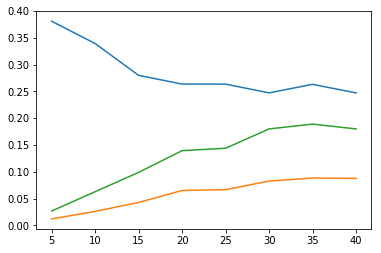

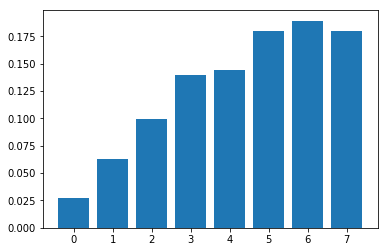

In [151]:
eval_data = pd.DataFrame(ae_evals[-8:])
eval_data = eval_data.sort_values(by='epochs_trained')
import matplotlib.pyplot as plt
plt.plot(eval_data['epochs_trained'], eval_data['diversity@5'])
plt.plot(eval_data['epochs_trained'], eval_data['map@5'])
plt.plot(eval_data['epochs_trained'], eval_data['map@1'])
plt.show()
plt.bar(eval_data.index, eval_data['map@1'])
plt.show()

In [ ]:
np.array([])